# setup

In [1]:
# If on cluster, cwd is '/rds/general/user/nz423', not the project directory, breaking imports
import os
import sys
from pathlib import Path

project_dir = Path(os.getcwd()) / "random-feature-boosting"
if "rds" not in project_dir.parts:
    project_dir = project_dir.parent
    YPMSD_dir = Path("/home/nikita/hdd/Data/")
else:
    project_dir = project_dir.parent
    if str(project_dir) not in sys.path:
        sys.path.append(str(project_dir))
    YPMSD_dir = project_dir.parent / "Data"
    
class Config:
    project_dir = project_dir
    save_dir = project_dir / "save" / "largeScaleExperiments"
    results_dir = project_dir / "results" / "largeScaleExperiments"
    YPMSD_dir = YPMSD_dir

print(Config.project_dir)
print(Config.save_dir)
print(Config.results_dir)
print(Config.YPMSD_dir)

/home/nikita/Code/random-feature-boosting
/home/nikita/Code/random-feature-boosting/save/largeScaleExperiments
/home/nikita/Code/random-feature-boosting/results/largeScaleExperiments
/home/nikita/hdd/Data


In [2]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable
import time
import json
from pathlib import Path
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch import Tensor, tensor
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from largeScaleExperiments import get_ypmsd, get_covtype, evaluate_big_experiments_for_model
from optuna_kfoldCV import pytorch_load_openml_dataset
from models.end2end import End2EndMLPResNet
from models.xgboost_wrapper import XGBoostClassifierWrapper, XGBoostRegressorWrapper
from models.base import LogisticRegression, RidgeModule
from models.random_feature_representation_boosting import GradientRFRBoostClassifier, GradientRFRBoostRegressor

np.set_printoptions(precision=3, threshold=5) # Print options

In [3]:
def plot_model_comparison(
        models: list, 
        dataset_name: str, 
        train_sizes: list, 
        results_dir: Path = Config.results_dir,
        save_dir: Path = Config.save_dir,
        ):
    """Plot a comparison of model performance, training time, and inference time on a dataset. chatgpt plotting code!"""
    # Initialize dictionary to store results
    results = {model: {
        "sizes": [], 
        "scores": [], 
        "std": [],
        "fit_times": [],
        "fit_times_std": [],
        "inference_times": [],
        "inference_times_std": []
    } for model in models}

    # Load results for each model and size
    for model in models:
        for size in train_sizes:
            save_folder = save_dir / dataset_name
            filepath = save_folder / f"{model}_{size}.json"
            
            # Load and process the file if it exists
            if filepath.exists():
                print(f"Loading {filepath}")
                with open(filepath, 'r') as f:
                    data = json.load(f)
                
                # Extract scores
                if "score" in data:
                    scores = data["score"]
                    mean_score = np.mean(scores)
                    std_score = np.std(scores) if len(scores) > 1 else 0
                elif "mean_score" in data:
                    mean_score = data["mean_score"]
                    std_score = data.get("std_score", 0)
                
                # Extract times
                if "fit_time" in data:
                    fit_times = data["fit_time"]
                    mean_fit_time = np.mean(fit_times)
                    std_fit_time = np.std(fit_times) if len(fit_times) > 1 else 0
                
                if "inference_time" in data:
                    inference_times = data["inference_time"]
                    mean_inference_time = np.mean(inference_times)
                    std_inference_time = np.std(inference_times) if len(inference_times) > 1 else 0
                
                # Save all results
                results[model]["sizes"].append(size)
                results[model]["scores"].append(mean_score)
                results[model]["std"].append(std_score)
                results[model]["fit_times"].append(mean_fit_time)
                results[model]["fit_times_std"].append(std_fit_time)
                results[model]["inference_times"].append(mean_inference_time)
                results[model]["inference_times_std"].append(std_inference_time)
            else:
                print(f"Warning: No file found for {model} with size {size}")

    # Define a color map for the models - ensure enough colors and markers for all models
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    markers = ['o', 's', '^', 'D', 'x', '+', '*', 'v', '<', '>']
    
    # Make sure we have enough markers and colors for all models
    while len(markers) < len(models):
        markers.extend(markers[:len(models)-len(markers)])
    while len(colors) < len(models):
        colors.extend(colors[:len(models)-len(colors)])

    # 1. Plot model performance
    plt.figure(figsize=(6, 6))
    
    for i, model in enumerate(models):
        sizes = results[model]["sizes"]
        
        if not sizes:  # Skip if no data for this model
            print(f"No data found for model: {model}")
            continue
            
        scores = results[model]["scores"]
        std = results[model]["std"]
        
        # Check if we have negative scores (RMSE values)
        if all(s < 0 for s in scores if s is not None and not np.isnan(s)):
            scores = [-s for s in scores]
            plt.ylabel("RMSE (lower is better)")
        else:
            plt.ylabel("Accuracy")
        
        # Sort by size
        if sizes:
            sorted_indices = np.argsort(sizes)
            sizes = [sizes[i] for i in sorted_indices]
            scores = [scores[i] for i in sorted_indices]
            std = [std[i] for i in sorted_indices]
        
        # Plot the line with error bands
        plt.plot(sizes, scores, marker=markers[i], linewidth=2, label=model, color=colors[i])
        
        if std[0] > 0:  # Only add error bands if std exists
            plt.fill_between(sizes, 
                            [scores[i] - std[i] for i in range(len(scores))],
                            [scores[i] + std[i] for i in range(len(scores))],
                            alpha=0.2, color=colors[i])

    plt.xlabel("Training Set Size")
    plt.xscale('log', base=2)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.title(f"Model Performance on {dataset_name}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(results_dir / f"{dataset_name}_model_performance.png", dpi=300)
    plt.show()

    # 2. Plot training time
    plt.figure(figsize=(6, 6))
    
    for i, model in enumerate(models):
        sizes = results[model]["sizes"]
        
        if not sizes:  # Skip if no data for this model
            continue
            
        fit_times = results[model]["fit_times"]
        fit_times_std = results[model]["fit_times_std"]
        
        # Sort by size
        if sizes:
            sorted_indices = np.argsort(sizes)
            sizes = [sizes[i] for i in sorted_indices]
            fit_times = [fit_times[i] for i in sorted_indices]
            fit_times_std = [fit_times_std[i] for i in sorted_indices]
        
        # Plot the line with error bands
        plt.plot(sizes, fit_times, marker=markers[i], linewidth=2, label=model, color=colors[i % len(colors)])
        
        if fit_times_std[0] > 0:  # Only add error bands if std exists
            plt.fill_between(sizes, 
                            [fit_times[i] - fit_times_std[i] for i in range(len(fit_times))],
                            [fit_times[i] + fit_times_std[i] for i in range(len(fit_times))],
                            alpha=0.2, color=colors[i % len(colors)])

    plt.xlabel("Training Set Size")
    plt.ylabel("Training Time")
    plt.xscale('log', base=2)
    plt.yscale('log')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.title(f"Model Training Time on {dataset_name}")
    plt.legend()
    plt.tight_layout()
    plt.savefig(results_dir / f"{dataset_name}_training_time.png", dpi=300)
    plt.show()

# YPMSD Regression

In [ ]:
dataset_name = "YPMSD"
X_train, y_train, X_test, y_test = get_ypmsd(Config.YPMSD_dir / "YPMSD.csv")
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(X_train.device)
#train: first 463,715 examples
#test: last 51,630 examples

In [ ]:
#rfrboost
evaluate_big_experiments_for_model(
    param_grid = {
        "in_dim": [X_train.shape[1]],
        "out_dim": [y_train.shape[1]],
        "n_layers": [1, 3, 6],
        "l2_ghat": [0.1, 0.01, 0.001, 0.0001, 0.00001],
        "l2_reg": [None],
        "boost_lr": [1.0],
        "feature_type": ["SWIM"],
        "upscale_type": ["identity"],
        "use_batchnorm": [False],
    },
    modelClass = GradientRFRBoostRegressor,
    model_name="RFRBoost",
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
    dataset_name=dataset_name,
    reg_or_cls="regression",
    train_sizes = [2000, 2000, 4000, 8000, 16000, 32000, 64000,
                   128000, 256000, 463715],
    model_rerun_seeds = [0, 1, 2, 3, 4],
    save_dir=Config.save_dir,
)

In [ ]:
#RFNN
evaluate_big_experiments_for_model(
    param_grid = {
        "in_dim": [X_train.shape[1]],
        "out_dim": [y_train.shape[1]],
        "n_layers": [0],
        "hidden_dim": [512],
        "l2_reg": [0.1, 0.01, 0.001, 0.0001, 0.00001],
        "upscale_type": ["SWIM"],
        "use_batchnorm": [False],
    },
    modelClass = GradientRFRBoostRegressor,
    model_name="RFNN",
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
    dataset_name=dataset_name,
    reg_or_cls="regression",
    train_sizes = [2000, 2000, 4000, 8000, 16000, 32000, 64000,
                   128000, 256000, 463715],
    model_rerun_seeds = [0, 1, 2, 3, 4],
    save_dir=Config.save_dir,
)

In [ ]:
#ridge
evaluate_big_experiments_for_model(
    param_grid = {
        "l2_reg": [0.1, 0.01, 0.001, 0.0001, 0.00001],
    },
    modelClass = RidgeModule,
    model_name="Ridge",
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
    dataset_name=dataset_name,
    reg_or_cls="regression",
    train_sizes = [2000, 2000, 4000, 8000, 16000, 32000, 64000,
                   128000, 256000, 463715],
    model_rerun_seeds = [0, 1, 2, 3, 4],
    save_dir=Config.save_dir,
)

In [ ]:
# xgboost
evaluate_big_experiments_for_model(
    param_grid = {
        "objective": ["reg:squarederror"],
        "learning_rate": [0.01, 0.033, 0.1],
        "n_estimators": [250, 500, 1000],
        "max_depth": [1, 3, 6, 10],
        "lambda": [1],
        "device": [str(X_train.device)],
    },
    modelClass = XGBoostRegressorWrapper,
    model_name="XGBoost",
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
    dataset_name=dataset_name,
    reg_or_cls="regression",
    train_sizes = [2000, 2000, 4000, 8000, 16000, 32000, 64000,
                   128000, 256000, 463715],
    model_rerun_seeds = [0, 1, 2, 3, 4],
    save_dir=Config.save_dir,
)

In [ ]:
#e2e mlp resnet
evaluate_big_experiments_for_model(
    param_grid = {
        'loss': ["mse"],
        "in_dim": [X_train.shape[1]],
        "out_dim": [y_train.shape[1]],
        'bottleneck_dim': [512],
        "n_blocks": [3],
        'lr': [0.1, 0.01, 0.001],
        'n_epochs': [10, 20, 30],
        'end_lr_factor': [0.01],
        'weight_decay': [1e-5],
        'batch_size': [256],
        'upsample': [False],
        "hidden_dim": [X_train.shape[1]],
    },
    modelClass = End2EndMLPResNet,
    model_name="E2E MLP ResNet",
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
    dataset_name=dataset_name,
    reg_or_cls="regression",
    train_sizes = [2000, 2000, 4000, 8000, 16000, 32000, 64000,
                   128000, 256000, 463715],
    model_rerun_seeds = [0, 1, 2, 3, 4],
    save_dir=Config.save_dir,
)

In [ ]:
plot_model_comparison(
    models = ["Ridge", "RFNN", "RFRBoost", "E2E MLP ResNet", "XGBoost"],
    dataset_name = dataset_name,
    train_sizes = [2000, 2000, 4000, 8000, 16000, 32000, 64000,
                   128000, 256000, 463715],
)

# CovType

In [ ]:
dataset_name = "CoverType"
X_train, y_train, X_test, y_test = get_covtype()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(X_train.device)

In [ ]:
#RFRBoost
evaluate_big_experiments_for_model(
    param_grid = {
        "in_dim": [X_train.shape[1]],
        "n_classes": [y_train.shape[1]],
        "n_layers": [1, 3, 6],
        "l2_cls": [None],
        "l2_ghat": [0.1, 0.01, 0.001, 0.0001, 0.00001],
        "boost_lr": [1.0],
        "feature_type": ["SWIM"],
        "upscale_type": ["identity"],
        "use_batchnorm": [False],
    },
    modelClass = GradientRFRBoostClassifier,
    model_name="RFRBoost",
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
    dataset_name=dataset_name,
    reg_or_cls="classification",
    train_sizes = [2000, 2000, 4000, 8000, 16000, 32000, 64000, 
                   128000, 256000, 464809],
    model_rerun_seeds = [0, 1, 2, 3, 4],
    save_dir=Config.save_dir,
)

In [ ]:
#RFNN
evaluate_big_experiments_for_model(
    param_grid = {
        "in_dim": [X_train.shape[1]],
        "n_classes": [y_train.shape[1]],
        "n_layers": [0],
        "l2_cls": [0.1, 0.01, 0.001, 0.0001, 0.00001],
        "upscale_type": ["SWIM"],
        "hidden_dim": [512],
        "use_batchnorm": [False],
    },
    modelClass = GradientRFRBoostClassifier,
    model_name="RFNN",
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
    dataset_name=dataset_name,
    reg_or_cls="classification",
    train_sizes = [2000, 2000, 4000, 8000, 16000, 32000, 64000, 
                   128000, 256000, 464809],
    model_rerun_seeds = [0, 1, 2, 3, 4],
    save_dir=Config.save_dir,
)

In [ ]:
# Logistic Regression
evaluate_big_experiments_for_model(
    param_grid = {
        "n_classes": [y_train.shape[1]],
        "l2_lambda": [0.1, 0.01, 0.001, 0.0001, 0.00001],
        "lr": [1.0],
        "max_iter": [300],
    },
    modelClass = LogisticRegression,
    model_name="Logistic Regression",
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
    dataset_name=dataset_name,
    reg_or_cls="classification",
    train_sizes = [2000, 2000, 4000, 8000, 16000, 32000, 64000, 
                   128000, 256000, 464809],
    model_rerun_seeds = [0, 1, 2, 3, 4],
    save_dir=Config.save_dir,
)

In [ ]:
#XGBoost
evaluate_big_experiments_for_model(
    param_grid = {
        "objective": ["multi:softmax"],
        "learning_rate": [0.01, 0.033, 0.1],
        "n_estimators": [250, 500, 1000],
        "max_depth": [1, 3, 6, 10],
        "lambda": [1],
        "device": [str(X_train.device)],
    },
    modelClass = XGBoostClassifierWrapper,
    model_name="XGBoost",
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
    dataset_name=dataset_name,
    reg_or_cls="classification",
    train_sizes = [2000, 2000, 4000, 8000, 16000, 32000, 64000, 
                   128000, 256000, 464809],
    model_rerun_seeds = [0, 1, 2, 3, 4],
    save_dir=Config.save_dir,
)

In [ ]:
#e2e mlp resnet
evaluate_big_experiments_for_model(
    param_grid = {
        'loss': ["cce"],
        "in_dim": [X_train.shape[1]],
        "out_dim": [y_train.shape[1]],
        'bottleneck_dim': [512],
        "n_blocks": [3],
        'lr': [0.1, 0.01, 0.001],
        'n_epochs': [10, 20, 30],
        'end_lr_factor': [0.01],
        'weight_decay': [1e-5],
        'batch_size': [256],
        'upsample': [False],
        "hidden_dim": [X_train.shape[1]],
    },
    modelClass = End2EndMLPResNet,
    model_name="E2E MLP ResNet",
    X_train = X_train.to("cuda"),
    X_test = X_test.to("cuda"),
    y_train = y_train.to("cuda"),
    y_test = y_test.to("cuda"),
    dataset_name=dataset_name,
    reg_or_cls="classification",
    train_sizes = [2000, 2000, 4000, 8000, 16000, 32000, 64000, 
                   128000, 256000, 464809],
    model_rerun_seeds = [0, 1, 2, 3, 4],
    save_dir=Config.save_dir,
)

In [ ]:
plot_model_comparison(
    models = ["Logistic Regression", "RFNN", "RFRBoost", "E2E MLP ResNet", "XGBoost"],
    dataset_name = dataset_name,
    train_sizes = [2000, 2000, 4000, 8000, 16000, 32000, 64000, 
                   128000, 256000, 464809],
)

# wave_energy id 44975  largest openml reg

In [ ]:
dataset_name = "OpenML ID 44975"
X, y = pytorch_load_openml_dataset(
    dataset_id=44975,
    regression_or_classification="regression",
    device="cuda",
    max_samples=1000000,
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.11, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
#rfrboost
evaluate_big_experiments_for_model(
    param_grid = {
        "in_dim": [X_train.shape[1]],
        "out_dim": [y_train.shape[1]],
        "n_layers": [1, 3, 6],
        "l2_reg": [None],
        "l2_ghat": [0.1, 0.01, 0.001, 0.0001, 0.00001],
        "boost_lr": [1.0],
        "feature_type": ["SWIM"],
        "upscale_type": ["identity"],
        "use_batchnorm": [False],
    },
    modelClass = GradientRFRBoostRegressor,
    model_name="RFRBoost",
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
    dataset_name=dataset_name,
    reg_or_cls="regression",
    train_sizes = [2000, 2000, 4000, 8000, 16000, 32000, 64000],
    model_rerun_seeds = [0, 1, 2, 3, 4],
    save_dir=Config.save_dir,
)

In [ ]:
#RFNN
evaluate_big_experiments_for_model(
    param_grid = {
        "in_dim": [X_train.shape[1]],
        "out_dim": [y_train.shape[1]],
        "n_layers": [0],
        "hidden_dim": [512],
        "l2_reg": [0.1, 0.01, 0.001, 0.0001, 0.00001],
        "upscale_type": ["SWIM"],
        "use_batchnorm": [False],
    },
    modelClass = GradientRFRBoostRegressor,
    model_name="RFNN",
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
    dataset_name=dataset_name,
    reg_or_cls="regression",
    train_sizes = [2000, 2000, 4000, 8000, 16000, 32000, 64000],
    model_rerun_seeds = [0, 1, 2, 3, 4],
    save_dir=Config.save_dir,
)

In [ ]:
#ridge
evaluate_big_experiments_for_model(
    param_grid = {
        "l2_reg": [0.1, 0.01, 0.001, 0.0001, 0.00001],
    },
    modelClass = RidgeModule,
    model_name="Ridge",
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
    dataset_name=dataset_name,
    reg_or_cls="regression",
    train_sizes = [2000, 2000, 4000, 8000, 16000, 32000, 64000],
    model_rerun_seeds = [0, 1, 2, 3, 4],
    save_dir=Config.save_dir,
)

In [ ]:
# xgboost
evaluate_big_experiments_for_model(
    param_grid = {
        "objective": ["reg:squarederror"],
        "learning_rate": [0.01, 0.033, 0.1],
        "n_estimators": [250, 500, 1000],
        "max_depth": [1, 3, 6, 10],
        "lambda": [1],
        "device": [str(X_train.device)],
    },
    modelClass = XGBoostRegressorWrapper,
    model_name="XGBoost",
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
    dataset_name=dataset_name,
    reg_or_cls="regression",
    train_sizes = [2000, 2000, 4000, 8000, 16000, 32000, 64000],
    model_rerun_seeds = [0, 1, 2, 3, 4],
    save_dir=Config.save_dir,
)

In [ ]:
#e2e mlp resnet
evaluate_big_experiments_for_model(
    param_grid = {
        'loss': ["mse"],
        "in_dim": [X_train.shape[1]],
        "out_dim": [y_train.shape[1]],
        'bottleneck_dim': [512],
        "n_blocks": [3],
        'lr': [0.1, 0.01, 0.001],
        'n_epochs': [10, 20, 30],
        'end_lr_factor': [0.01],
        'weight_decay': [1e-5],
        'batch_size': [256],
        'upsample': [False],
        "hidden_dim": [X_train.shape[1]],
    },
    modelClass = End2EndMLPResNet,
    model_name="E2E MLP ResNet",
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
    dataset_name=dataset_name,
    reg_or_cls="regression",
    train_sizes = [2000, 2000, 4000, 8000, 16000, 32000, 64000],
    model_rerun_seeds = [0, 1, 2, 3, 4],
    save_dir=Config.save_dir,
)

In [ ]:
plot_model_comparison(
    models = ["Ridge", "RFNN", "RFRBoost", "E2E MLP ResNet", "XGBoost"],
    dataset_name = dataset_name,
    train_sizes = [2000, 2000, 4000, 8000, 16000, 32000, 64000],
)

# 23517 classification largest openml cls

In [ ]:
dataset_name = "OpenML ID 23517"
X, y = pytorch_load_openml_dataset(
    dataset_id=23517,
    regression_or_classification="classification",
    device="cuda",
    max_samples=1000000,
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.336, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
#RFRBoost
evaluate_big_experiments_for_model(
    param_grid = {
        "in_dim": [X_train.shape[1]],
        "n_classes": [y_train.shape[1]],
        "n_layers": [1, 3, 6],
        "l2_cls": [None],
        "l2_ghat": [0.1, 0.01, 0.001, 0.0001, 0.00001],
        "boost_lr": [1.0],
        "feature_type": ["SWIM"],
        "upscale_type": ["identity"],
        "use_batchnorm": [False],
        "freeze_top_at_t": [0],
    },
    modelClass = GradientRFRBoostClassifier,
    model_name="RFRBoost",
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
    dataset_name=dataset_name,
    reg_or_cls="classification",
    train_sizes = [2000, 2000, 4000, 8000, 16000, 32000, 64000],
    model_rerun_seeds = [0, 1, 2, 3, 4],
    save_dir=Config.save_dir,
)

In [ ]:
#RFNN
evaluate_big_experiments_for_model(
    param_grid = {
        "in_dim": [X_train.shape[1]],
        "n_classes": [y_train.shape[1]],
        "n_layers": [0],
        "l2_cls": [0.1, 0.01, 0.001, 0.0001, 0.00001],
        "upscale_type": ["SWIM"],
        "hidden_dim": [512],
        "use_batchnorm": [False],
    },
    modelClass = GradientRFRBoostClassifier,
    model_name="RFNN",
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
    dataset_name=dataset_name,
    reg_or_cls="classification",
    train_sizes = [2000, 2000, 4000, 8000, 16000, 32000, 64000],
    model_rerun_seeds = [0, 1, 2, 3, 4],
    save_dir=Config.save_dir,
)

In [ ]:
#logistic regression
evaluate_big_experiments_for_model(
    param_grid = {
        "n_classes": [y_train.shape[1]],
        "l2_lambda": [0.1, 0.01, 0.001, 0.0001, 0.00001],
        "lr": [1.0],
        "max_iter": [300],
    },
    modelClass = LogisticRegression,
    model_name="Logistic Regression",
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
    dataset_name=dataset_name,
    reg_or_cls="classification",
    train_sizes = [2000, 2000, 4000, 8000, 16000, 32000, 64000],
    model_rerun_seeds = [0, 1, 2, 3, 4],
    save_dir=Config.save_dir,
)

In [ ]:
#xgboost
evaluate_big_experiments_for_model(
    param_grid = {
        "objective": ["binary:logistic"],
        "num_class": [y_train.shape[1]],
        "learning_rate": [0.01, 0.033, 0.1],
        "n_estimators": [250, 500, 1000],
        "max_depth": [1, 3, 6, 10],
        "lambda": [1],
    },
    modelClass = XGBoostClassifierWrapper,
    model_name="XGBoost",
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
    dataset_name=dataset_name,
    reg_or_cls="classification",
    train_sizes = [2000, 2000, 4000, 8000, 16000, 32000, 64000],
    model_rerun_seeds = [0, 1, 2, 3, 4],
    save_dir=Config.save_dir,
)

In [ ]:
#e2e mlp resnet
evaluate_big_experiments_for_model(
    param_grid = {
        'loss': ["bce"],
        "in_dim": [X_train.shape[1]],
        "out_dim": [y_train.shape[1]],
        'bottleneck_dim': [512],
        "n_blocks": [3],
        'lr': [0.1, 0.01, 0.001],
        'n_epochs': [10, 20, 30],
        'end_lr_factor': [0.01],
        'weight_decay': [1e-5],
        'batch_size': [256],
        'upsample': [False],
        "hidden_dim": [X_train.shape[1]],
    },
    modelClass = End2EndMLPResNet,
    model_name="E2E MLP ResNet",
    X_train = X_train,
    X_test = X_test,
    y_train = y_train,
    y_test = y_test,
    dataset_name=dataset_name,
    reg_or_cls="classification",
    train_sizes = [2000, 2000, 4000, 8000, 16000, 32000, 64000],
    model_rerun_seeds = [0, 1, 2, 3, 4],
    save_dir=Config.save_dir,
)

In [ ]:
plot_model_comparison(
    models = ["Logistic Regression", "RFNN", "RFRBoost", "E2E MLP ResNet", "XGBoost"],
    dataset_name = dataset_name,
    train_sizes = [2000, 2000, 4000, 8000, 16000, 32000, 64000],
)

# Combine Plots

Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/YPMSD/RFNN_2000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/YPMSD/RFNN_2000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/YPMSD/RFNN_4000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/YPMSD/RFNN_8000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/YPMSD/RFNN_16000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/YPMSD/RFNN_32000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/YPMSD/RFNN_64000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/YPMSD/RFNN_128000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/YPMSD/RFNN_256000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/YPMSD/RFNN_463715.json
Loading /ho

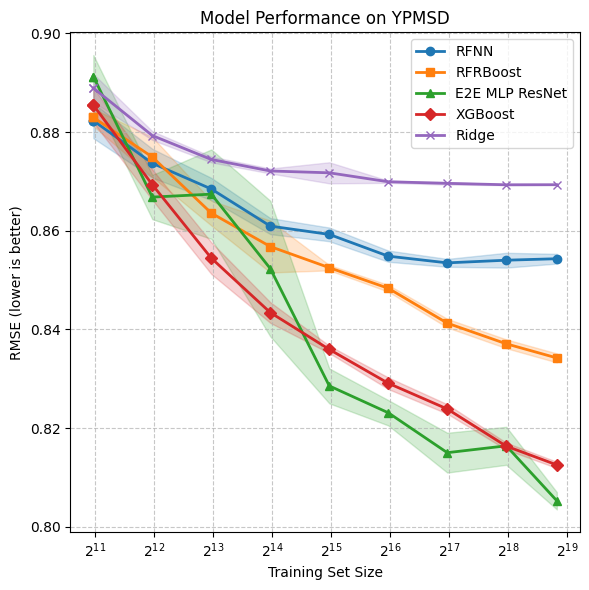

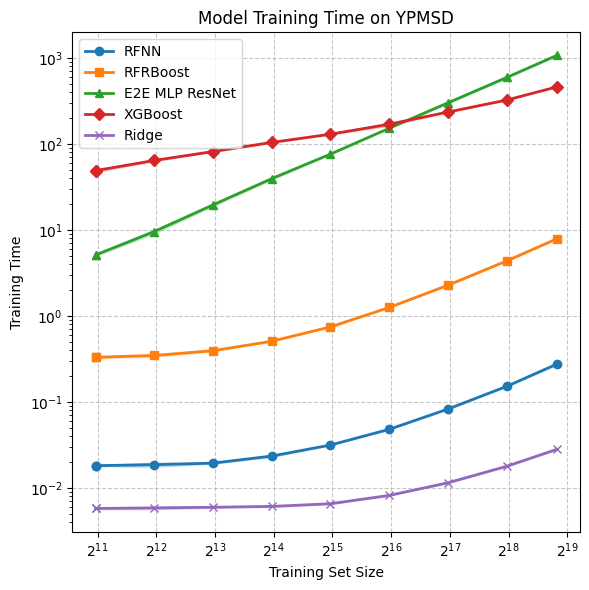

Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/CoverType/RFNN_2000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/CoverType/RFNN_2000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/CoverType/RFNN_4000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/CoverType/RFNN_8000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/CoverType/RFNN_16000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/CoverType/RFNN_32000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/CoverType/RFNN_64000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/CoverType/RFNN_128000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/CoverType/RFNN_256000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiment

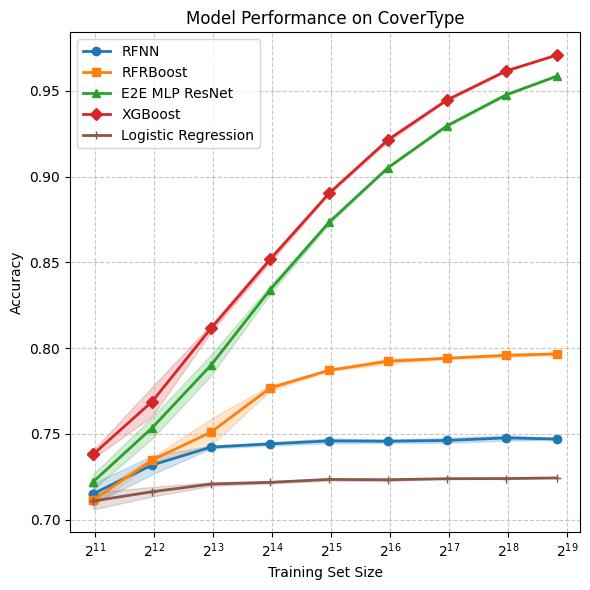

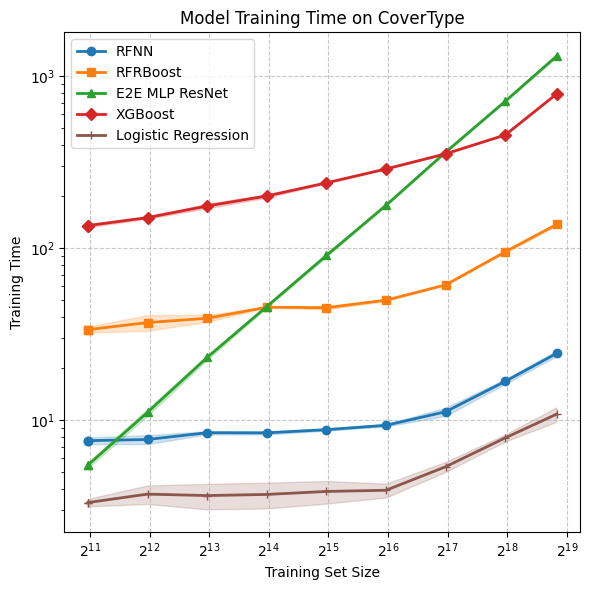

Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/OpenML ID 44975/RFNN_2000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/OpenML ID 44975/RFNN_2000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/OpenML ID 44975/RFNN_4000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/OpenML ID 44975/RFNN_8000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/OpenML ID 44975/RFNN_16000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/OpenML ID 44975/RFNN_32000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/OpenML ID 44975/RFNN_64000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/OpenML ID 44975/RFRBoost_2000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/OpenML ID 44975/RFRBoost_2000.json
Loading /home/nik

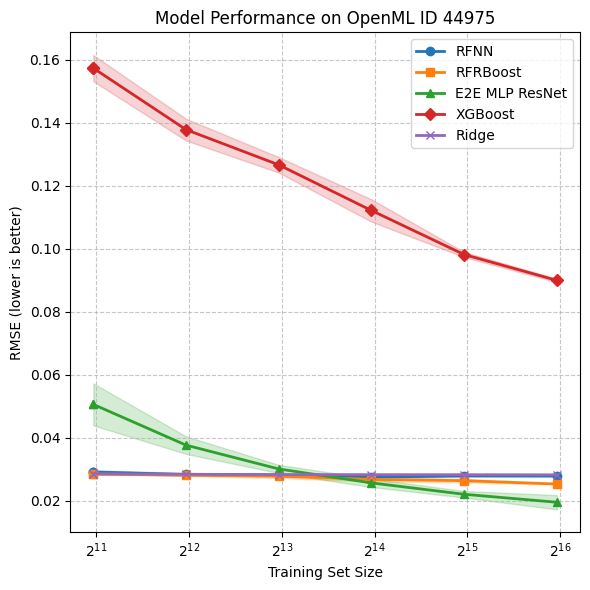

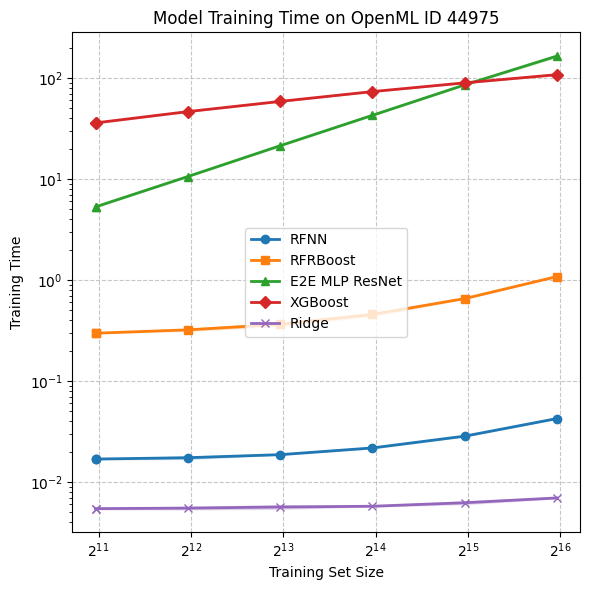

Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/OpenML ID 23517/RFNN_2000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/OpenML ID 23517/RFNN_2000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/OpenML ID 23517/RFNN_4000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/OpenML ID 23517/RFNN_8000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/OpenML ID 23517/RFNN_16000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/OpenML ID 23517/RFNN_32000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/OpenML ID 23517/RFNN_64000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/OpenML ID 23517/RFRBoost_2000.json
Loading /home/nikita/Code/random-feature-boosting/save/largeScaleExperiments/OpenML ID 23517/RFRBoost_2000.json
Loading /home/nik

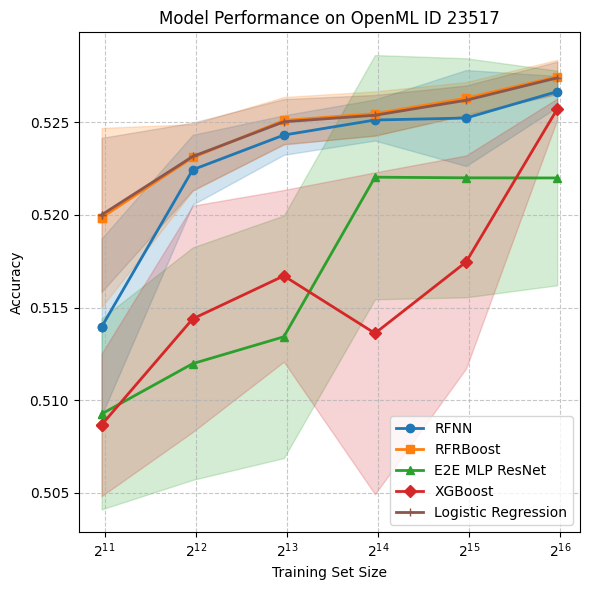

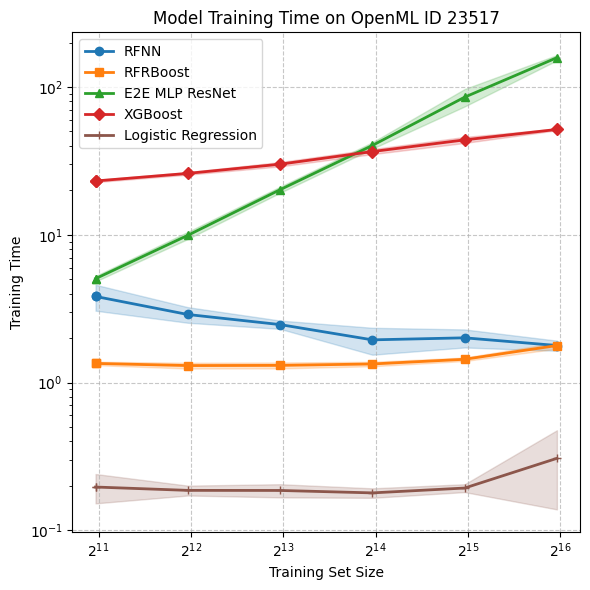

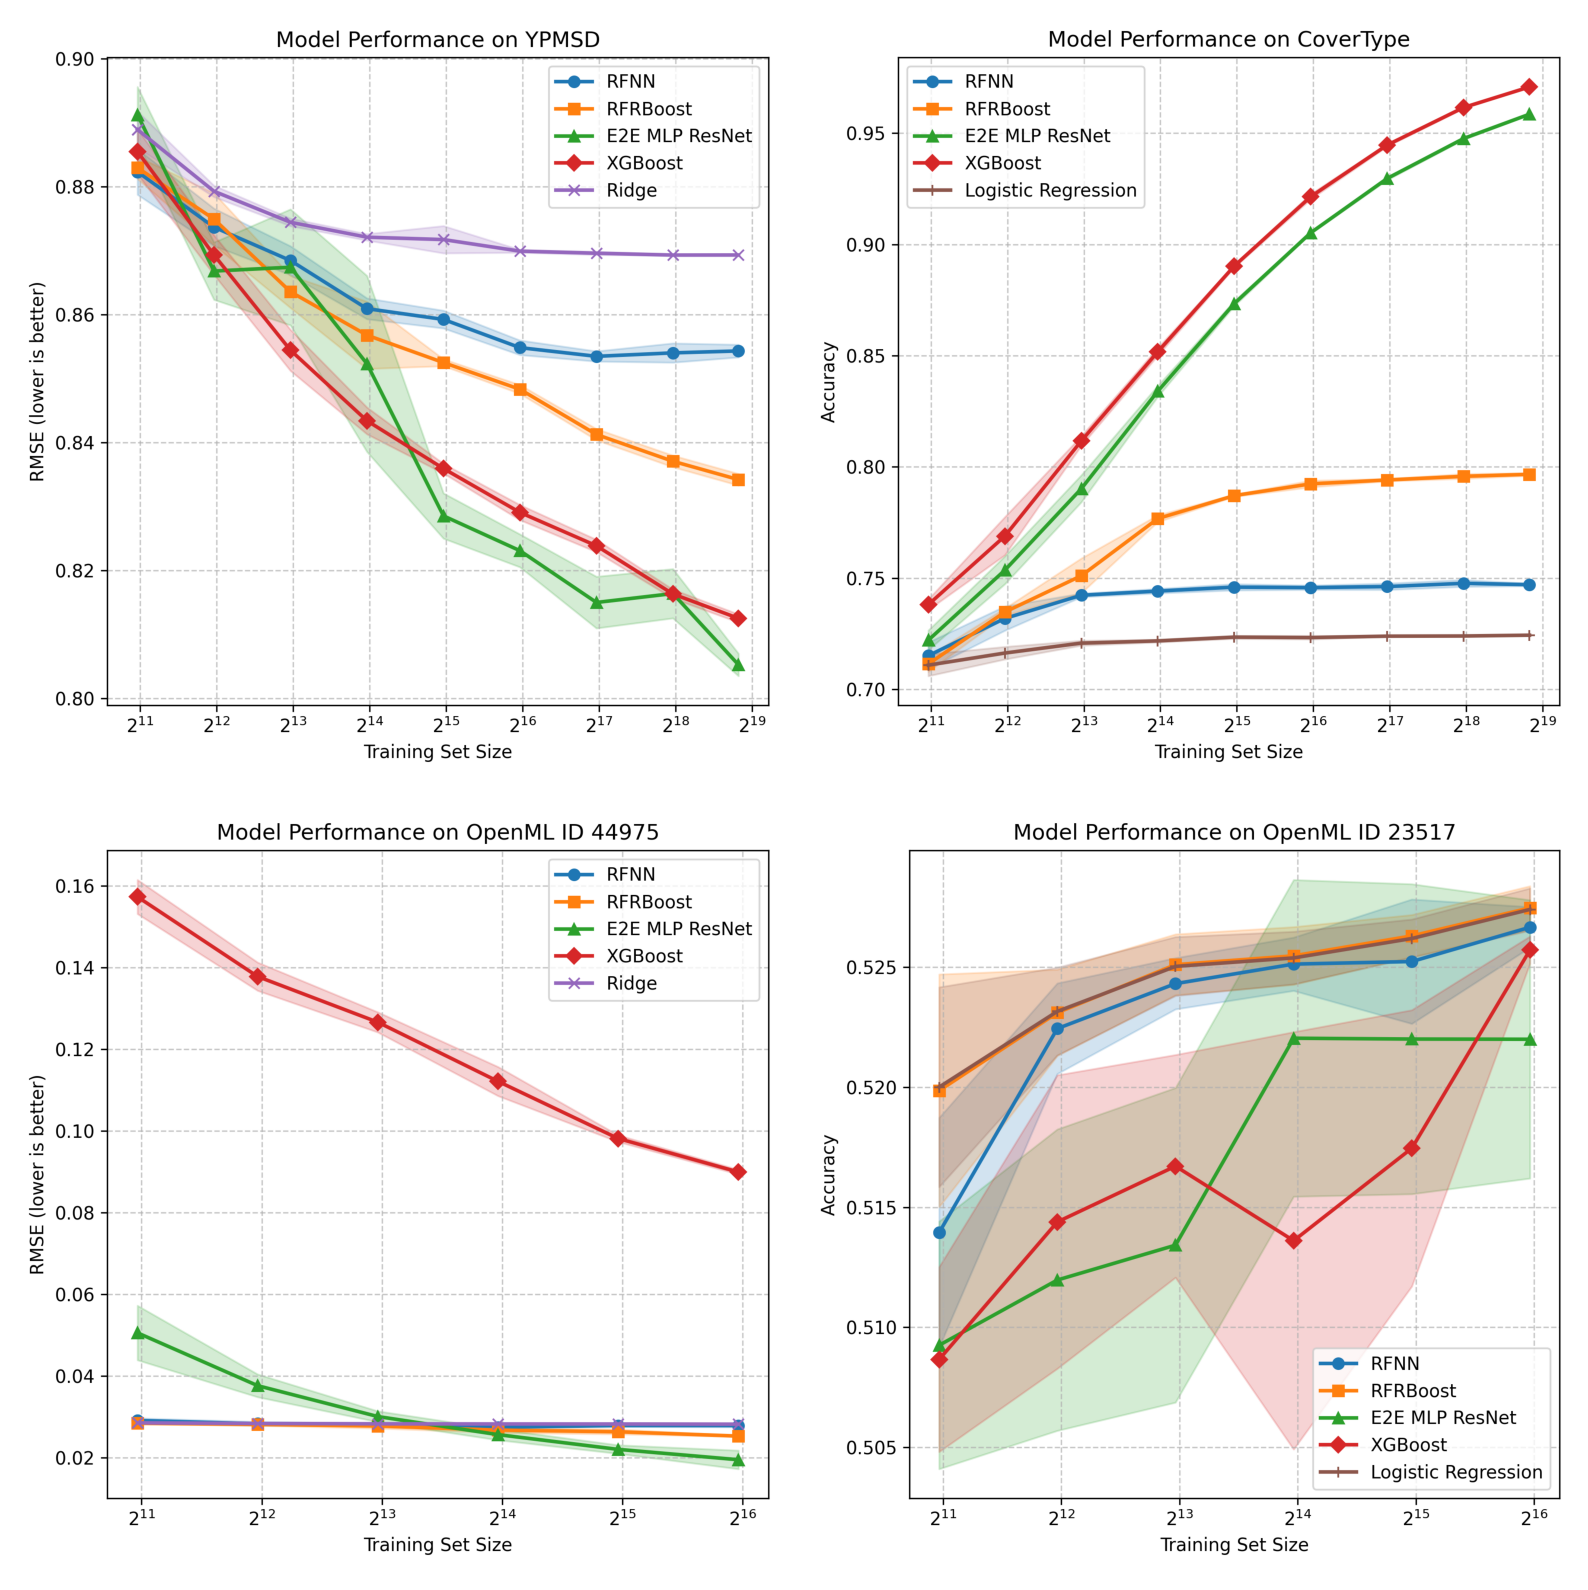

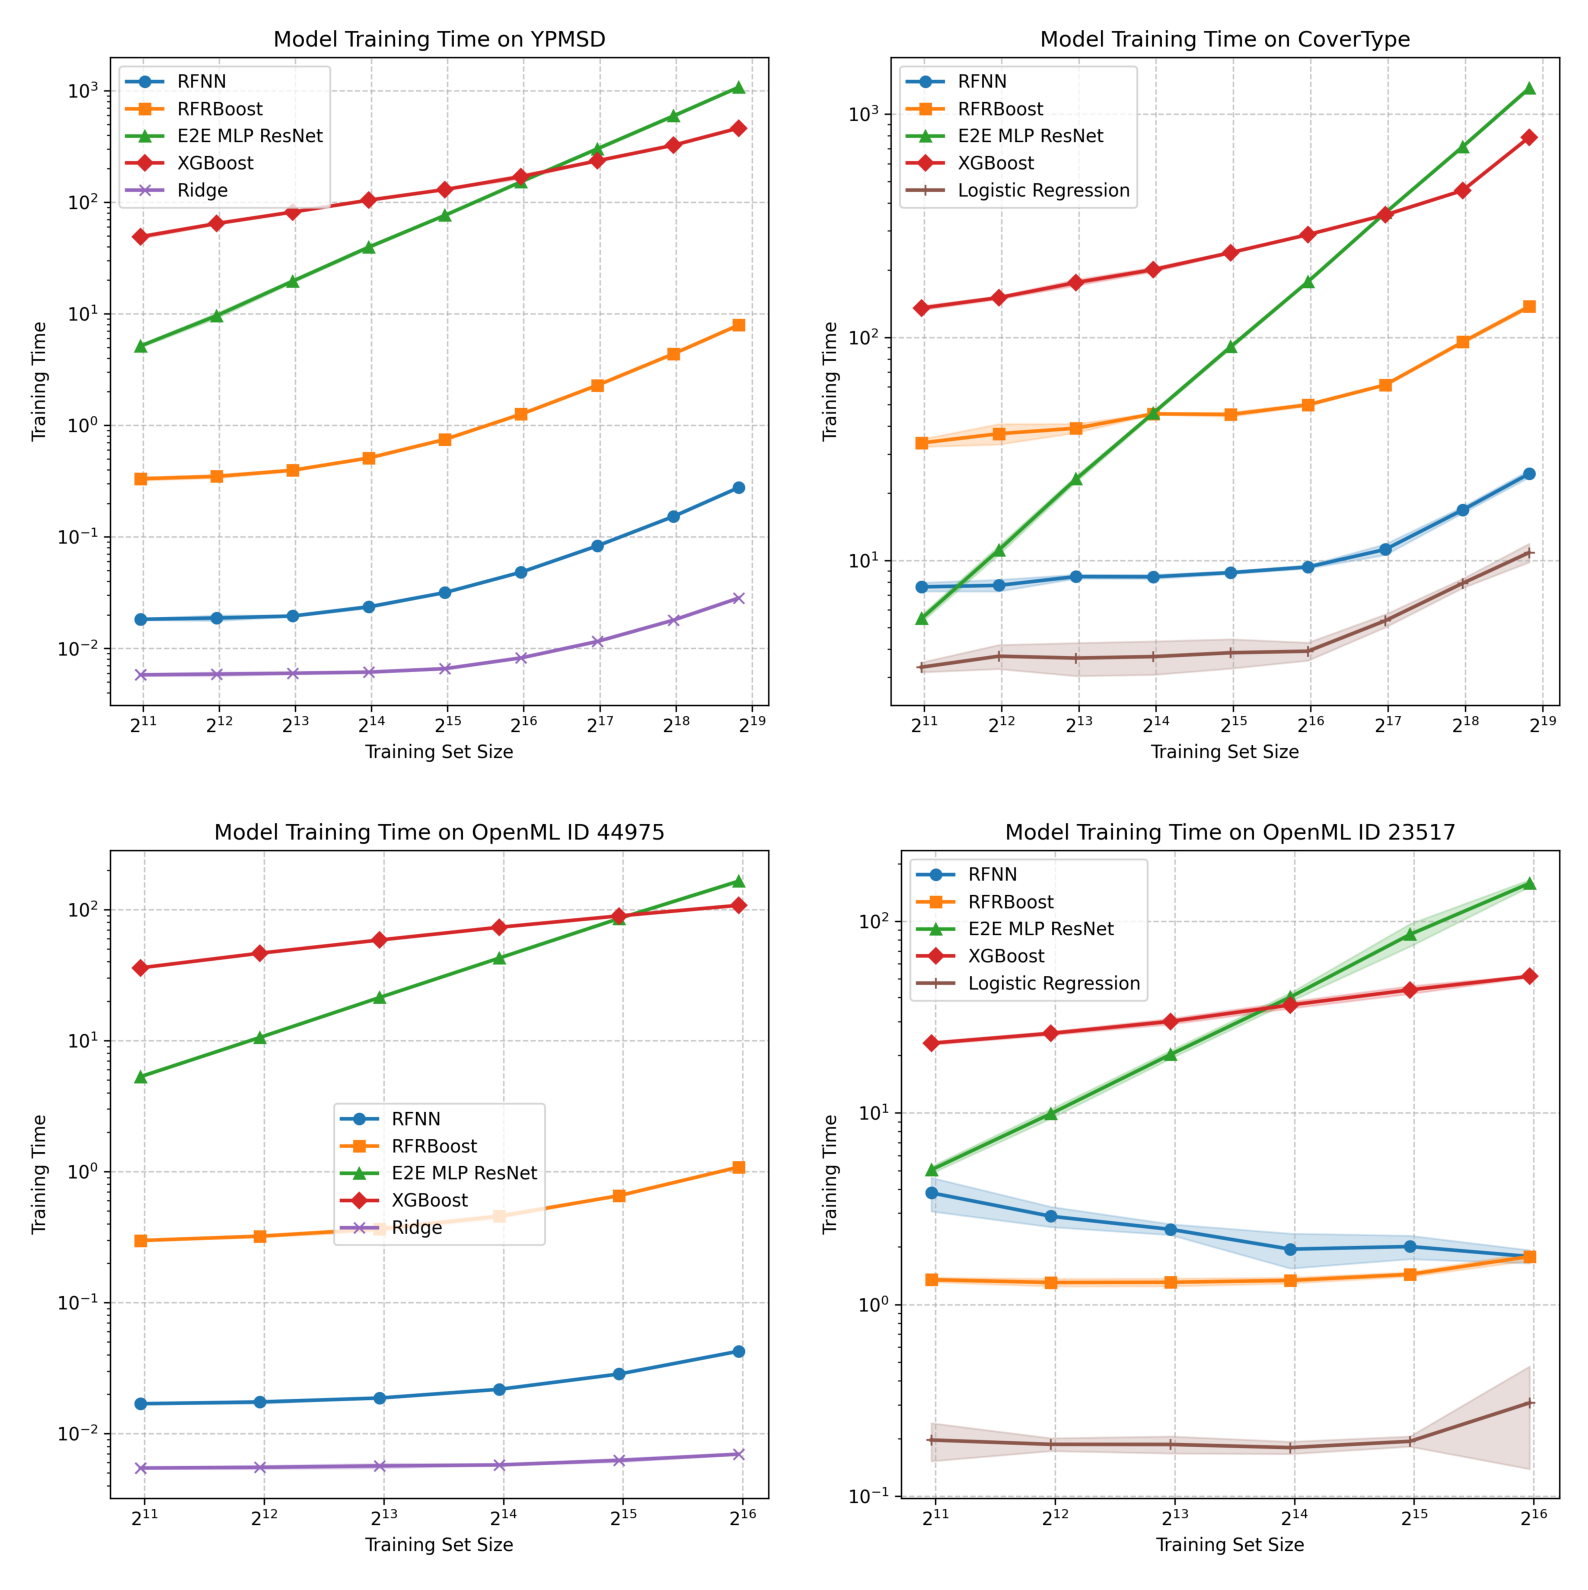

In [4]:
dataset_names = ["YPMSD", "CoverType", "OpenML ID 44975", "OpenML ID 23517"]

# create plots for all datasets
for dataset_name in dataset_names:
    plot_model_comparison(
        models = ["RFNN", "RFRBoost", "E2E MLP ResNet", "XGBoost", "Ridge", "Logistic Regression"],
        dataset_name = dataset_name,
        train_sizes = [2000, 2000, 4000, 8000, 16000, 32000, 64000,
                       128000, 256000, 463715, 464809],
    )

# combine 4 plots into a single figure on a 2x2 grid and save it
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = axes.flatten()

for i, dataset_name in enumerate(dataset_names):
    # Load the saved model performance image
    img_path = Config.results_dir / f"{dataset_name}_model_performance.png"
    img = plt.imread(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(Config.results_dir / "combined_model_performance.png", dpi=300, bbox_inches='tight')
plt.show()

# Do the same for training time plots
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = axes.flatten()

for i, dataset_name in enumerate(dataset_names):
    # Load the saved training time image
    img_path = Config.results_dir / f"{dataset_name}_training_time.png"
    img = plt.imread(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(Config.results_dir / "combined_training_time.png", dpi=300, bbox_inches='tight')
plt.show()